### Twitter Sentiment Analysis - Gov CDMX

In [11]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.python.lib.io import file_io

In [60]:
!export GOOGLE_APPLICATION_CREDENTIALS="/Users/admin/Downloads/gov-cdmx-twitter-sentiment-3479e766b2c0.json"
!export PATH="/usr/local/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/Users/admin/development/gov-cdmx-twitter-sentiment/streaming/env/bin:/usr/local/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/usr/local/sbin:/Users/admin/golang/bin:/usr/local/Cellar/go/1.13/libexec/bin:/Users/admin/lib:/Users/admin/golang/bin:/usr/local/Cellar/go/1.13/libexec/bin:/Users/admin/lib:/Library/TeX/texbin"

In [13]:
!pip install --upgrade google-api-python-client

Requirement already up-to-date: google-api-python-client in /Users/admin/development/gov-cdmx-twitter-sentiment/streaming/env/lib/python3.7/site-packages (1.9.3)


In [14]:
%!bq tables describe --name gov-cdmx-twitter-sentiment:gov_cdmx_twitter_sentiment.tweets

UsageError: Line magic function `%!bq` not found.


Now that the data is in bigquery we can save a section to cloud storage or grab it direct from bigquery.

In [29]:
with file_io.FileIO('gs://gov-cdmx-twitter-sentiment/nlpstorage/bq-results-20200616-001935-24xjrm1mtu7z.csv', 'r') as f:
    df = pd.read_csv(f)

In [ ]:
df.head()

In [ ]:
print(df['user_text'][0])
print(len(df['user_text']))

In [35]:
rts=df[df['user_text'].str.match('"RT')]
print("Retweets ", len(rts['user_text']))
cdmx=df[df['user_text'].str.contains('#CDMX')]
print("CDMX", len(cdmx['user_text']))

Retweets  0
CDMX 7229


In [ ]:
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
from google.oauth2 import service_account
from google.protobuf.json_format import MessageToDict

score=[]
magnitude=[]
creds = service_account.Credentials.from_service_account_file('/Users/admin/Downloads/gov-cdmx-twitter-sentiment-53dba8db6dbd.json')
client = language.LanguageServiceClient(credentials=creds)

for tweet in cdmx['user_text']:
    document = types.Document(
    content=tweet,
    type=enums.Document.Type.PLAIN_TEXT
    )
    analyze_sentiment_response = client.analyze_sentiment(document=document)
    message = MessageToDict(analyze_sentiment_response, including_default_value_fields=True)
    score.append(message['documentSentiment']['score'])
    magnitude.append(message['documentSentiment']['magnitude'])

print(len(score))
# print('POLARITY=%s MAGNITUDE=%s for %s' % (score, magnitude, tweet))

In [44]:
cdmx['score']=score
cdmx['magnitude']=magnitude
cdmx.head()

/Users/admin/development/gov-cdmx-twitter-sentiment/streaming/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/admin/development/gov-cdmx-twitter-sentiment/streaming/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tweet_timestamp,user_text,user_screen_nam,user_location,user_followers_count,score,magnitude
1,1591803071,CDMX presenta 80% en ocupación hospitalaria; s...,Revolucion3_0,México,142945,0.2,0.2
3,1591803071,"O sea, el convenio existe, se podría ver, pero...",PlusTijuana,NaN,304,0.0,0.8
4,1591803071,RT @Vanilla_Deluxe: 🔥🥰quiero besos muchooos be...,lelo69yahoo,NaN,146,0.3,0.3
5,1591803071,#SNTEsalud\n\nSi vas de casa🚶‍♀️🏡 a la tienda...,joycerosas,NaN,1753,0.2,1.1
7,1591803071,🌤️Buenos días cariño mío!!!!\nMe conoces ya? \...,BellapuntoG,Guadalajara,836,0.4,2.7


In [45]:
cdmx['datef']=pd.to_datetime(cdmx['tweet_timestamp'], unit='s', yearfirst='TRUE')
cdmx['datef'].head()

/Users/admin/development/gov-cdmx-twitter-sentiment/streaming/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1   2020-06-10 15:31:11
3   2020-06-10 15:31:11
4   2020-06-10 15:31:11
5   2020-06-10 15:31:11
7   2020-06-10 15:31:11
Name: datef, dtype: datetime64[ns]

In [46]:
#averages
score_avg=np.mean(cdmx['score'])
magnitude_evg=np.mean(cdmx['magnitude'])
print('score', score_avg, 'magnitude', magnitude_evg)

score 0.19434223267395215 magnitude 0.7552496887536313


Text(0, 0.5, 'Magnitude')

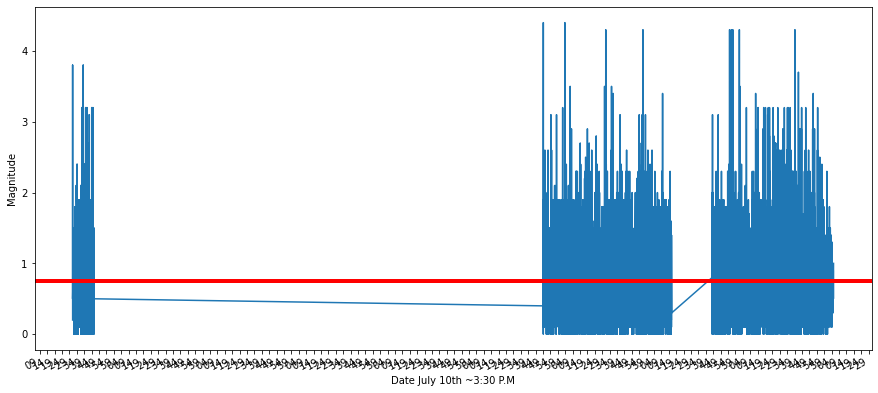

In [47]:
data = pd.concat([cdmx['datef'], cdmx['magnitude']], axis=1)
data.set_index('datef',inplace=True)
fig, ax = plt.subplots(figsize=(15,7))
data.plot(ax=ax, legend=False)
ax.axhline(y=magnitude_evg, linewidth=4, color='r')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax.set_xlabel('Date July 10th ~3:30 P.M')
ax.set_ylabel('Magnitude')

Text(0, 0.5, 'Score')

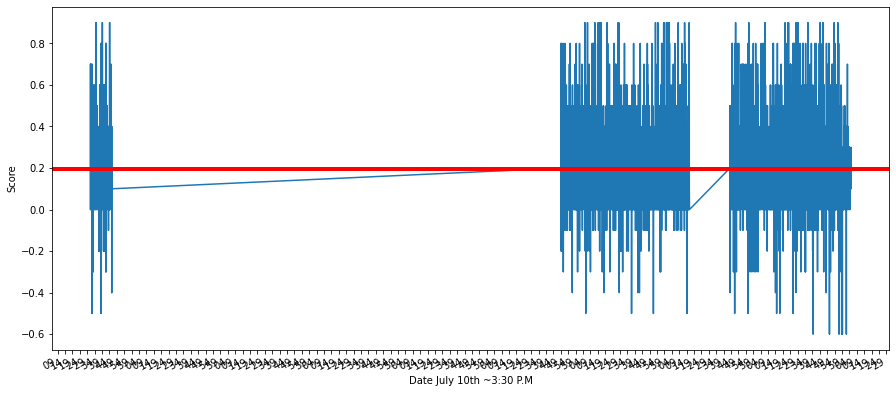

In [48]:
data2 = pd.concat([cdmx['datef'], cdmx['score']], axis=1)
data2.set_index('datef',inplace=True)
fig, ax2 = plt.subplots(figsize=(15,7))
data2.plot(ax=ax2, legend=False)
ax2.axhline(y=score_avg, linewidth=4, color='r')
ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax2.set_xlabel('Date July 10th ~3:30 P.M')
ax2.set_ylabel('Score')

High magnitude tweets are more impactful than low magnitude tweets, a weak statement doesn't say much.
We will concentrate only on statements with a magnitude of 0.5 or higher.

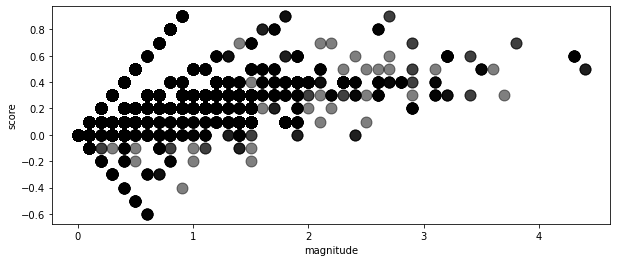

In [49]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(10,4)
ax.grid(False)
#ax.scatter(cdmx.magnitude[cdmx['magnitude'] >=0.5], cdmx.polarity[google['magnitude'] >=0.5], s=120, c='black', alpha=0.5)
ax.scatter(cdmx.magnitude, cdmx.score, s=120, c='black', alpha=0.5)
ax.set(xlabel='magnitude', ylabel='score')
plt.show()

We can also see that things around zero polarity (neither very positive nor negative) are not interesting to flag 

In [50]:
love=cdmx[(cdmx['magnitude'] >=0.5) & (cdmx['score'] >=0.5)]
hate=cdmx[(cdmx['magnitude'] >=0.5) & (cdmx['score'] <= -0.5)]

In [51]:
print(len(cdmx['magnitude']), len(love['magnitude']), len(hate['magnitude']))
print("weak", len(cdmx['magnitude']) - (len(love['magnitude'])+len(hate['magnitude'])))

7229 527 19
weak 6683


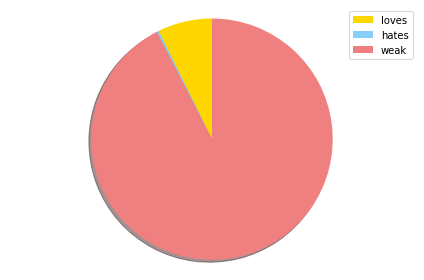

In [64]:
labels = ['loves', 'hates', 'weak']
sizes = [527, 19, 6683]
colors = ['gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

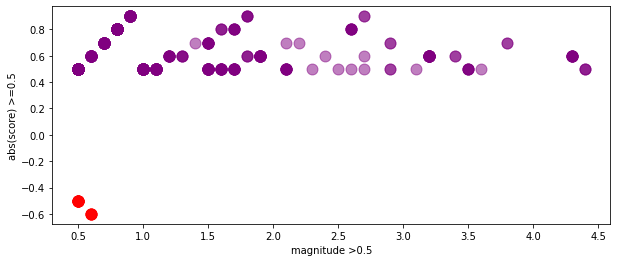

In [53]:
fig, ax= plt.subplots()
ax.scatter(love.magnitude, love.score, s=120, c='purple', alpha=0.5)
ax.scatter(hate.magnitude, hate.score, s=120, c='red', alpha=0.5)
ax.figure.set_size_inches(10,4)
ax.grid(False) 
ax.set(xlabel='magnitude >0.5', ylabel='abs(score) >=0.5')
plt.show()

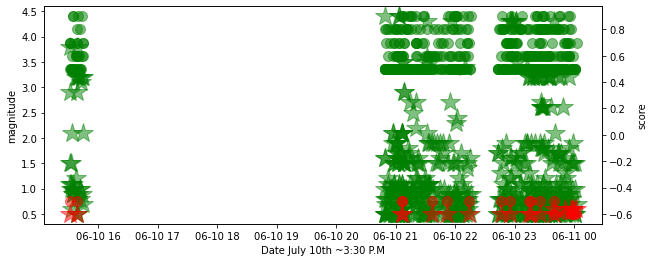

In [54]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Date July 10th ~3:30 P.M')
ax1.set_ylabel('magnitude')
ax1.grid(False)
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax1.figure.set_size_inches(10,4)
ax1.plot(love['datef'], love['magnitude'], 'g*', markersize=20, alpha=0.5)
ax1.plot(hate['datef'], hate['magnitude'], 'r*', markersize=20, alpha=0.5)
ax2=ax1.twinx()
ax2.grid(False)
ax2.plot(love.datef, love.score, 'g.', markersize=20, alpha=0.5)
ax2.plot(hate.datef, hate.score, 'r.', markersize=20, alpha=0.5)
ax2.set_ylabel('score')
#ax2.axhline(y=polavg, linewidth=4, color='r')
plt.show()

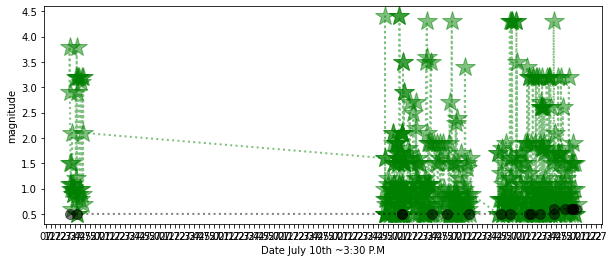

In [55]:
fig, ax = plt.subplots()
ax.set_xlabel('Date July 10th ~3:30 P.M')
ax.grid(False)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax.figure.set_size_inches(10,4)
ax.plot(love['datef'], love['magnitude'], 'g', linestyle=':', marker='*', linewidth=2, markersize=20, alpha=0.5)
ax.plot(hate['datef'], hate['magnitude'], 'k', linestyle=':', marker='.', linewidth=2, markersize=20, alpha=0.5)
ax.set_ylabel('magnitude')
plt.show()

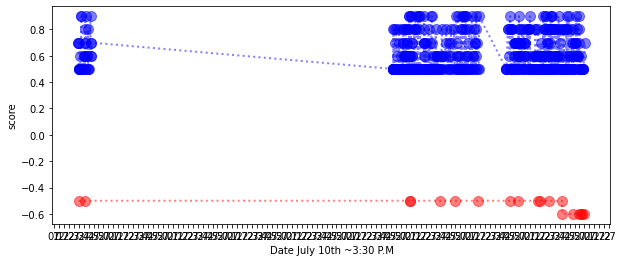

In [56]:
fig, ax = plt.subplots()
ax.set_xlabel('Date July 10th ~3:30 P.M')
ax.set_ylabel('score')
ax.grid(False)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax.figure.set_size_inches(10,4)
ax.plot(love['datef'], love['score'], 'b', linestyle=':', marker='.', linewidth=2, markersize=20, alpha=0.5)
ax.plot(hate['datef'], hate['score'], 'r', linestyle=':', marker='.', linewidth=2, markersize=20, alpha=0.5)
plt.show()